# The representation of women in the movie industry around the world

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import pycountry
import pycountry_convert as pc
import swifter

from functools import lru_cache
from scipy import stats
from itertools import islice
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression

In [2]:
current_directory = os.getcwd()

DATA_PATH = os.path.join(current_directory, 'MovieSummaries')
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHARACTER_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
CHARACTER_TYPE_PATH = os.path.join(DATA_PATH, 'tvtropes.clusters.txt')
RATINGS_PATH = os.path.join(current_directory, 'Ratings_PreProcessed.tsv')

---

### GENERAL ANALYSIS

We will start by analysing the main differences we can find between the representation of men and women in the movie industry.

---

### DATA PREPROCESSING

For this analysis, we will use the files movies.metadata and characters.metadata. 

In [3]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [4]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu = movies.merge(characters, how='left', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate'])
cmu = cmu.drop('DoB', axis=1)
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
162648,11011055,/m/02qy0f5,Flowers in the Attic,1987-11-20,15151736.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",NaN,F,1.676,/m/065b6q,Kristy Swanson,17.0,/m/02vb690,NaN,/m/0337zp
194392,18906899,/m/04jd3vt,Escape by Night,1953-12,NaN,79.0,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,M,NaN,NaN,Ted Ray,NaN,/m/0g5vfkv,NaN,/m/013sfd


In [5]:
from functions import convert_date

# Keep only the rows for which we have the gender of the actor/actress
cmu = cmu.loc[cmu['Gender'].isin(['F', 'M'])].copy(deep=True)

# The movie 'Hunting Season' has an incorrect data: 1010 instead of 2010
cmu['ReleaseDate'] = cmu['ReleaseDate'].replace('1010-12-02', '2010-12-02')
# Convert the date in the column 'ReleaseDate' into datetime
ReleaseDate_datatime = cmu['ReleaseDate'].apply(convert_date)
# Add a column with the year of release only
cmu['ReleaseYear'] = ReleaseDate_datatime.dt.year.fillna(0).astype(int)
cmu['ReleaseYear'] = cmu['ReleaseYear'].astype('int64')
cmu['ReleaseYear'].replace(0, np.nan, inplace=True)

# Convert the str-like dictionaries to dictionaries
cmu['Countries'] = cmu['Countries'].apply(ast.literal_eval)
cmu['MovieGenre'] = cmu['MovieGenre'].apply(ast.literal_eval)
cmu['Languages'] = cmu['Languages'].apply(ast.literal_eval)

# Remove outliers for age and replace null or negative values by NaN
cmu['Age'] = cmu['Age'].apply(lambda x: np.nan if x <= 0 else x)

# Keep only movies between 1912 and 2012 to have at least 200 movies per year
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1912) & (cmu['ReleaseYear'] <= 2012)]

# Keep only movies after 1925 to have at least 100 characters per year
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1912) & (cmu['ReleaseYear'] <= 2012)]

# Drop outliers for height
Q1 = cmu['Height'].quantile(0.25)
Q3 = cmu['Height'].quantile(0.75)
IQR = Q3 - Q1
cmu = cmu[(cmu['Height'] > Q1 - 1.5 * IQR) & (cmu['Height'] < Q3 + 1.5 * IQR)]

# Drop outliers for Runtime
lower, upper = 40, 180
cmu = cmu[(cmu['Runtime'] >= lower) & (cmu['Runtime'] <= upper)]

In [6]:
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
105195,1971197,/m/069zfs,The King of Jazz,1930-08-17,NaN,105.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/0hcr': 'Animation'},NaN,M,1.700,/m/033tf_,Bing Crosby,27.0,/m/02vbnzf,NaN,/m/01vsy9_,1930.0
104832,10087605,/m/02q1cs7,Where There's a Will,2006,NaN,80.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/07s9rl0': 'Drama', '/m/01z4y': 'Comedy', ...",NaN,M,1.854,NaN,Keith Carradine,56.0,/m/04htxgp,NaN,/m/03lmzl,2006.0


---

## AGE: IS THERE A DIFFERENCE ?

---

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

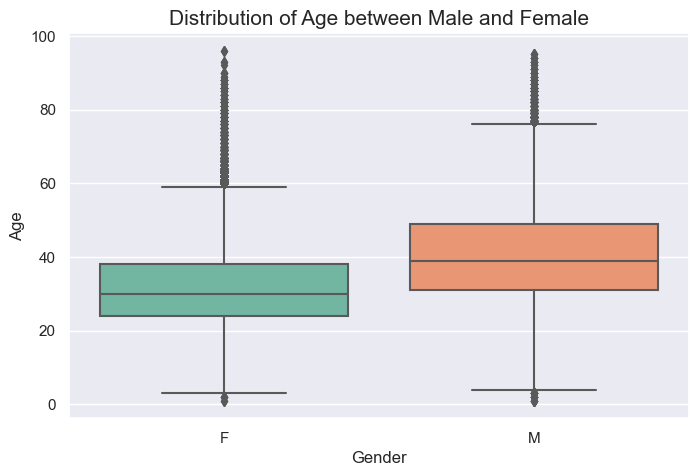

In [7]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [8]:
women_cmu = cmu.loc[cmu['Gender']=='F'].copy(deep=True)
men_cmu = cmu.loc[cmu['Gender']=='M'].copy(deep=True)

In [9]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_cmu['Age'], men_cmu['Age'], nan_policy='omit')

TtestResult(statistic=-104.28126043126201, pvalue=0.0, df=124768.0)

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.

### Has this tendency evolved with years ?

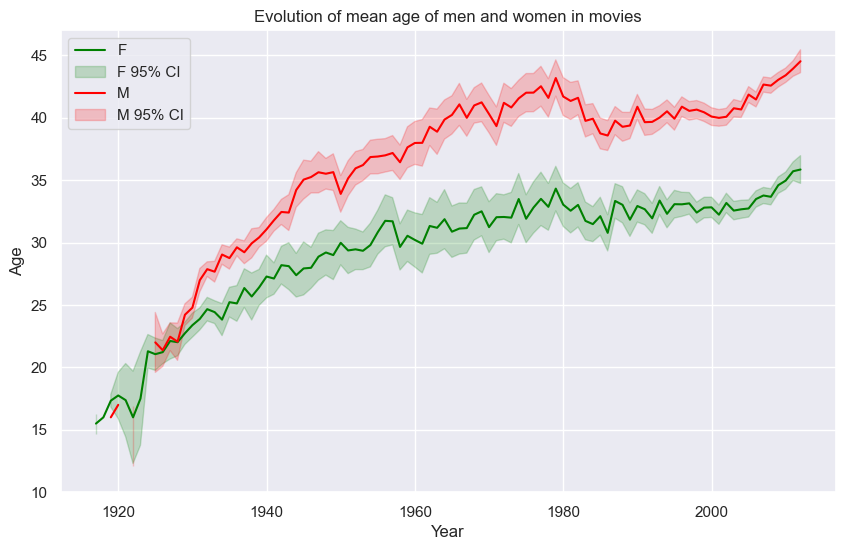

In [10]:
# Calculate the average age of actors and actresses in movies across year
women_mean_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})
men_mean_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})

# Calculate the 95% CIs
women_std_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'std'})
men_std_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'std'})

z=1.96
upper_bound_women = women_mean_age_per_year['Age'] + z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_women = women_mean_age_per_year['Age'] - z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])

upper_bound_men = men_mean_age_per_year['Age'] + z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_men = men_mean_age_per_year['Age'] - z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])

# Plot the evolution of mean age of men and women in movies
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(women_mean_age_per_year, label='F', color='green')
ax.fill_between(women_mean_age_per_year.index, lower_bound_women, upper_bound_women, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(men_mean_age_per_year, label='M', color='red')
ax.fill_between(men_mean_age_per_year.index, lower_bound_men, upper_bound_men, alpha =0.2, color='red', label = 'M 95% CI')

ax.set_ylim(10,47)
ax.set_xlabel('Year')
ax.set_ylabel('Age')
ax.set_title('Evolution of mean age of men and women in movies')
ax.legend()

plt.show()

---

## PROPORTION OF FEMALE CHARACTERS

---

We will explore the proportion of female characters in movies.

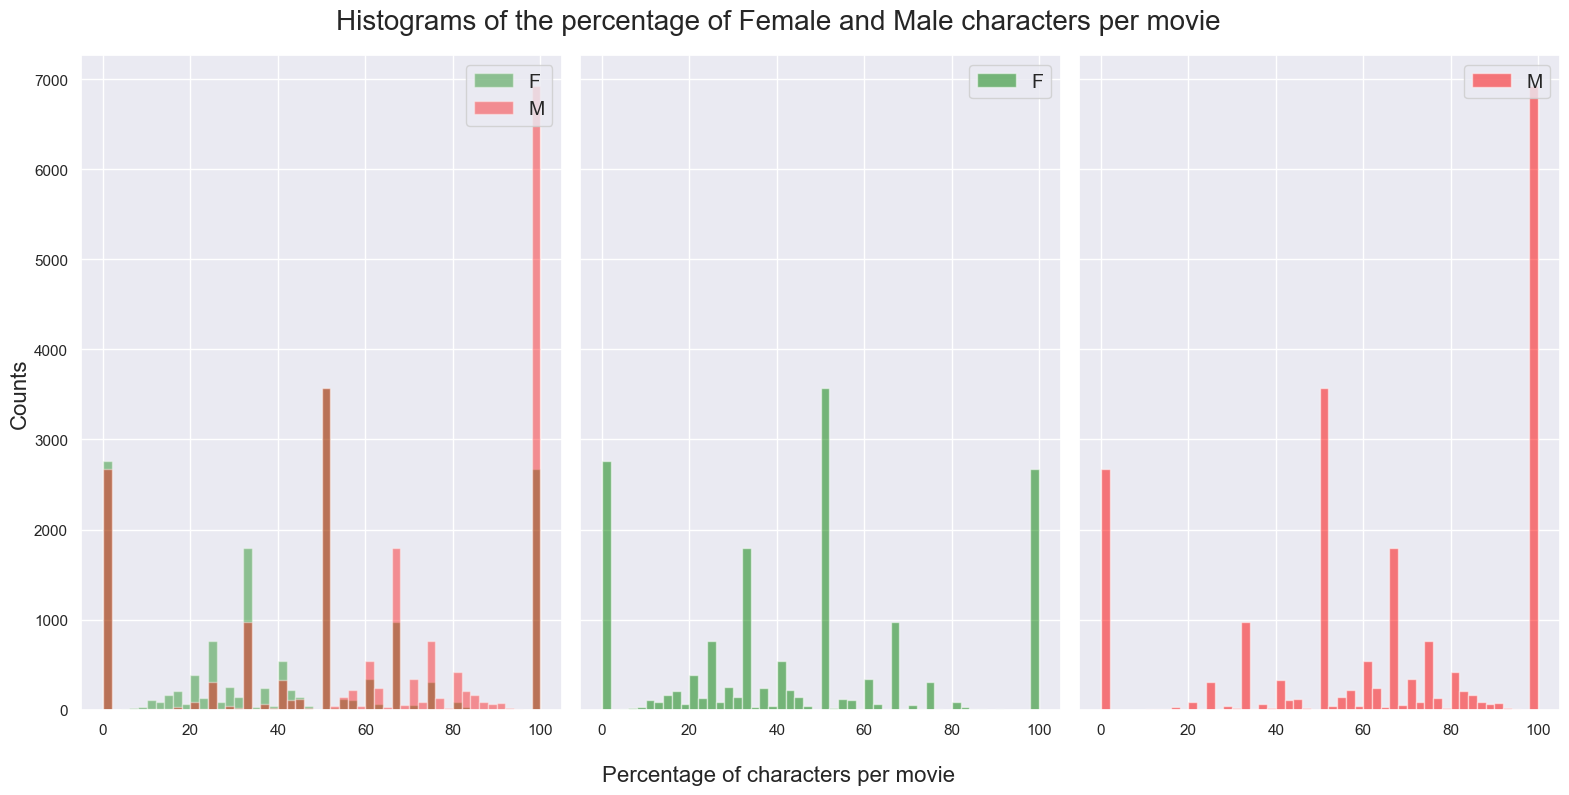

In [11]:
df_gender_proportion_by_movie=pd.DataFrame()

df_gender_proportion_by_movie['MaleCharacters'] = men_cmu.groupby('WikiMovieID')['CharacterName'].nunique()
df_gender_proportion_by_movie['FemaleCharacters'] = women_cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie['TotalNumberofCharacters'] = cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie = df_gender_proportion_by_movie.merge(cmu[['ReleaseYear', 'WikiMovieID']], how='left', left_index=True, right_on='WikiMovieID' )

df_gender_proportion_by_movie['PercentageofFemale'] = df_gender_proportion_by_movie['FemaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100
df_gender_proportion_by_movie['PercentageofMale'] = df_gender_proportion_by_movie['MaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100

df_gender_proportion_by_movie =df_gender_proportion_by_movie.drop_duplicates(subset=['WikiMovieID'])

#Plot
fig, ax = plt.subplots(1, 3, figsize=(16,8), sharey=True)

ax[0].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='F', alpha=0.4, color='green')
ax[0].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='M', alpha=0.4, color='red')
ax[0].legend(loc='upper right', fontsize=14) 

ax[1].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='F', alpha=0.5, color='green')
ax[1].legend(loc='upper right', fontsize=14) 


ax[2].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='M', alpha=0.5, color='red')
ax[2].legend(loc='upper right', fontsize=14) 

fig.supxlabel('Percentage of characters per movie', fontsize=16)
fig.supylabel('Counts', va='center', rotation=90, fontsize=16)
fig.suptitle('Histograms of the percentage of Female and Male characters per movie', fontsize=20)

plt.tight_layout()

plt.show()

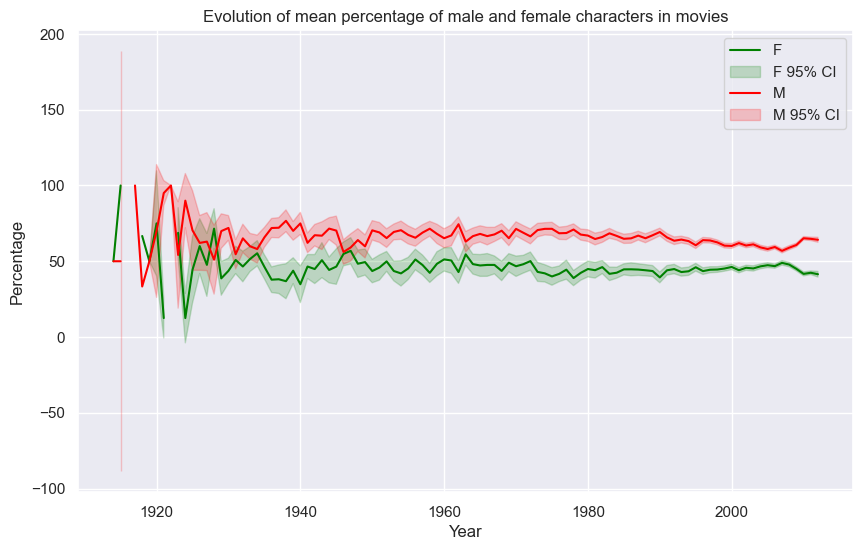

In [12]:
#Calculate the mean percentage of actors and actresses in movies across year
percentage_of_women_by_movie = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofFemale':'mean'})
percentage_of_men_by_movie = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofMale':'mean'})

#Calculate the 95% CIs
women_std_perc_per_year = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofFemale':'std'})
men_std_perc_per_year = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofMale':'std'})

z=1.96
upper_bound_women = percentage_of_women_by_movie['PercentageofFemale'] + z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_women = percentage_of_women_by_movie['PercentageofFemale'] - z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])

upper_bound_men = percentage_of_men_by_movie['PercentageofMale'] + z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_men = percentage_of_men_by_movie['PercentageofMale'] - z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])

#Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(percentage_of_women_by_movie, label='F', color='green')
ax.fill_between(lower_bound_women.index, lower_bound_women, upper_bound_women, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(percentage_of_men_by_movie, label='M', color='red')
ax.fill_between(lower_bound_men.index, lower_bound_men, upper_bound_men, alpha =0.2, color='red', label = 'M 95% CI')

#ax.set_ylim(0,101)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Evolution of mean percentage of male and female characters in movies')
ax.legend()
plt.show()

---

## GENRE OF MOVIE: IS THERE A DIFFERENCE ?

---

An often-repeated stereotype regarding women suggests that they are not inclined towards action, sports, or intellectual pursuits, but rather, their primary role is portrayed as being centered around romantic relationships. We aim to investigate whether this stereotype is reflected in the portrayal of women in movies from our dataset.

We will do our analysis only based on the 16 major genres of movie in the dataset. First, we need to determine what these 16 genres are.

In [13]:
# Filter the cmu dataset to get only 1 row per movie. Otherwise, the genres are counted too many times
cmu_without_duplicates = cmu.drop_duplicates(subset=['WikiMovieID'], keep='first')

In [14]:
all_unique_genres = set()

# Get all the movie genres
cmu_without_duplicates['MovieGenre'].apply(lambda x: all_unique_genres.update(x.values()) if isinstance(x, dict) else None)

# Initialize dictionary with keys and values set to 0
genres_count = {genre: 0 for genre in all_unique_genres}

# Count the occurence of each genre
for row in cmu_without_duplicates['MovieGenre']:
    for key, value in row.items():
        genres_count[value]+=1
        
# Sort the dictionary by values in descending order
genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

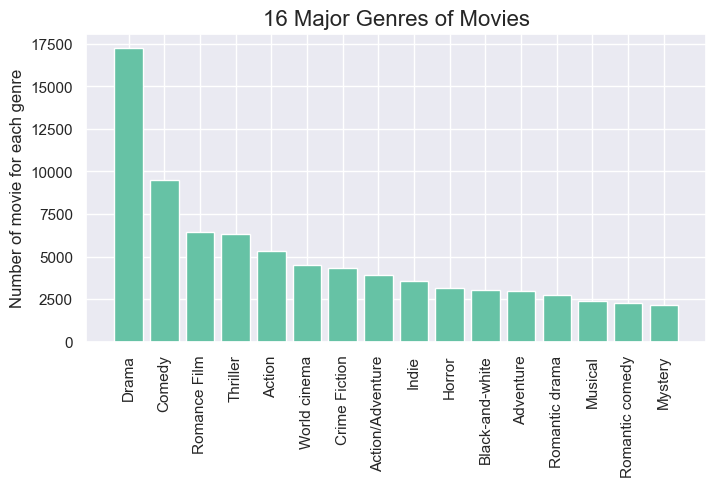

In [15]:
plt.figure(figsize=(8, 4))

# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

x = np.arange(len(major_16_genres))

plt.bar(x, major_16_genres.values())
plt.xticks(x, major_16_genres.keys(), rotation='vertical')
plt.title('16 Major Genres of Movies', fontsize=16)
plt.ylabel('Number of movie for each genre')
plt.show()

For the analysis we consider that:
- If a movie has several genres, we will keep the one that appears in the 16 major genres, and if several are in the 16 major genres, we keep the first one.
- If none is in the 16 major genre, or if the genre is not given, then we drop the row

In [16]:
# List of rows to drop 
rows_to_drop = []

cmu_genre = cmu.copy()

for index, row in cmu_genre.iterrows():
    movie_genre = row['MovieGenre']
    
    # If there is one genre only, drop the row if not in the 16 major genre
    if len(movie_genre) == 1 and list(movie_genre.values())[0] not in major_16_genres:
        rows_to_drop.append(index)
        
    # If there is no genre, drop the corresponding row
    elif not bool(movie_genre):
        rows_to_drop.append(index)
            
    # If there are multiple genres        
    else:
        count = 0  # To keep the first value only
        for key, value in movie_genre.items():
            if value in major_16_genres:
                if count == 0:
                    value_to_keep = value
                    key_to_keep = key
                    count = 1
                    break

        if count == 0:  # If none of the genres is in the major_16_genres, drop the row
            rows_to_drop.append(index)

        if count == 1:
            cmu_genre.at[index, 'MovieGenre'] = {key_to_keep: value_to_keep}

# Create a new DataFrame with only the rows to keep
cmu_genre = cmu_genre.drop(rows_to_drop)
movie_counts = cmu_genre['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

We are left with 31920 movies


To facilitate analysis, we replace the dictionary for the 'MovieGenre' column with a str:

In [17]:
cmu_genre['MovieGenre'] = cmu_genre['MovieGenre'].apply(lambda x: list(x.values())[0])

In [18]:
# Split the dataset in 2 according to actor gender
women_with_genre = cmu_genre.loc[cmu_genre['Gender']=='F'].copy(deep=True)
men_with_genre = cmu_genre.loc[cmu_genre['Gender']=='M'].copy(deep=True)

In [19]:
# Group by 'MovieGenre' and count the number of occurence
women_genre_counts = women_with_genre.groupby('MovieGenre').size().reset_index(name='Women_Count')
men_genre_counts = men_with_genre.groupby('MovieGenre').size().reset_index(name='Men_Count')

# New dataframe with the counts
genre_counts = women_genre_counts.merge(men_genre_counts, how='left', on='MovieGenre')

# Compute the percentage of Women and Men per movie genre
genre_counts['Percent_Women']=(genre_counts['Women_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100
genre_counts['Percent_Men']=(genre_counts['Men_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100

In [20]:
genre_counts.sample(2)

,MovieGenre,Women_Count,Men_Count,Percent_Women,Percent_Men
5,Crime Fiction,3801,8728,30.337617,69.662383
0,Action,928,2468,27.326266,72.673734


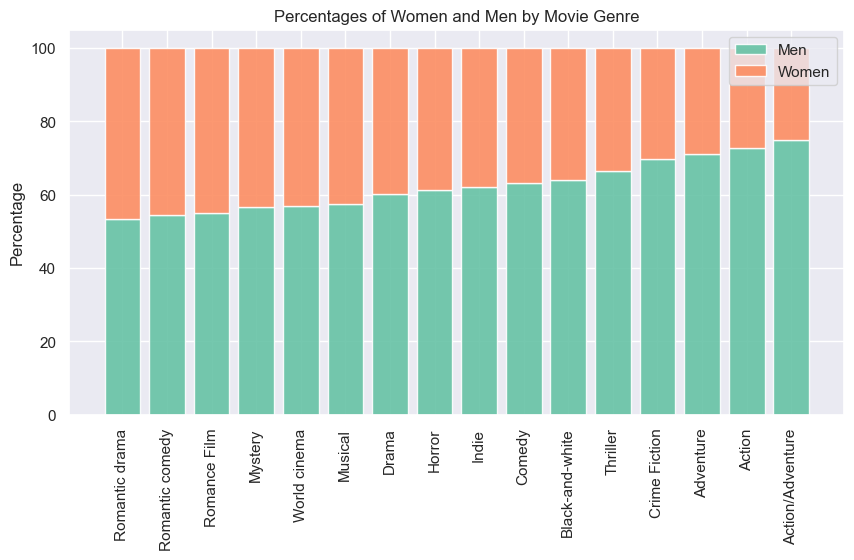

In [21]:
# Plot the percentage of Women and Men per movie genre

# Sort the DataFrame for better visualization
genre_counts = genre_counts.sort_values(by='Percent_Men', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Men'], label='Men', alpha=0.9)
ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Women'], bottom=genre_counts['Percent_Men'], label='Women', alpha=0.9)

plt.xticks(rotation='vertical')
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Women and Men by Movie Genre')
ax.legend()

plt.show()

Is there a difference in actors' ages between genres? 

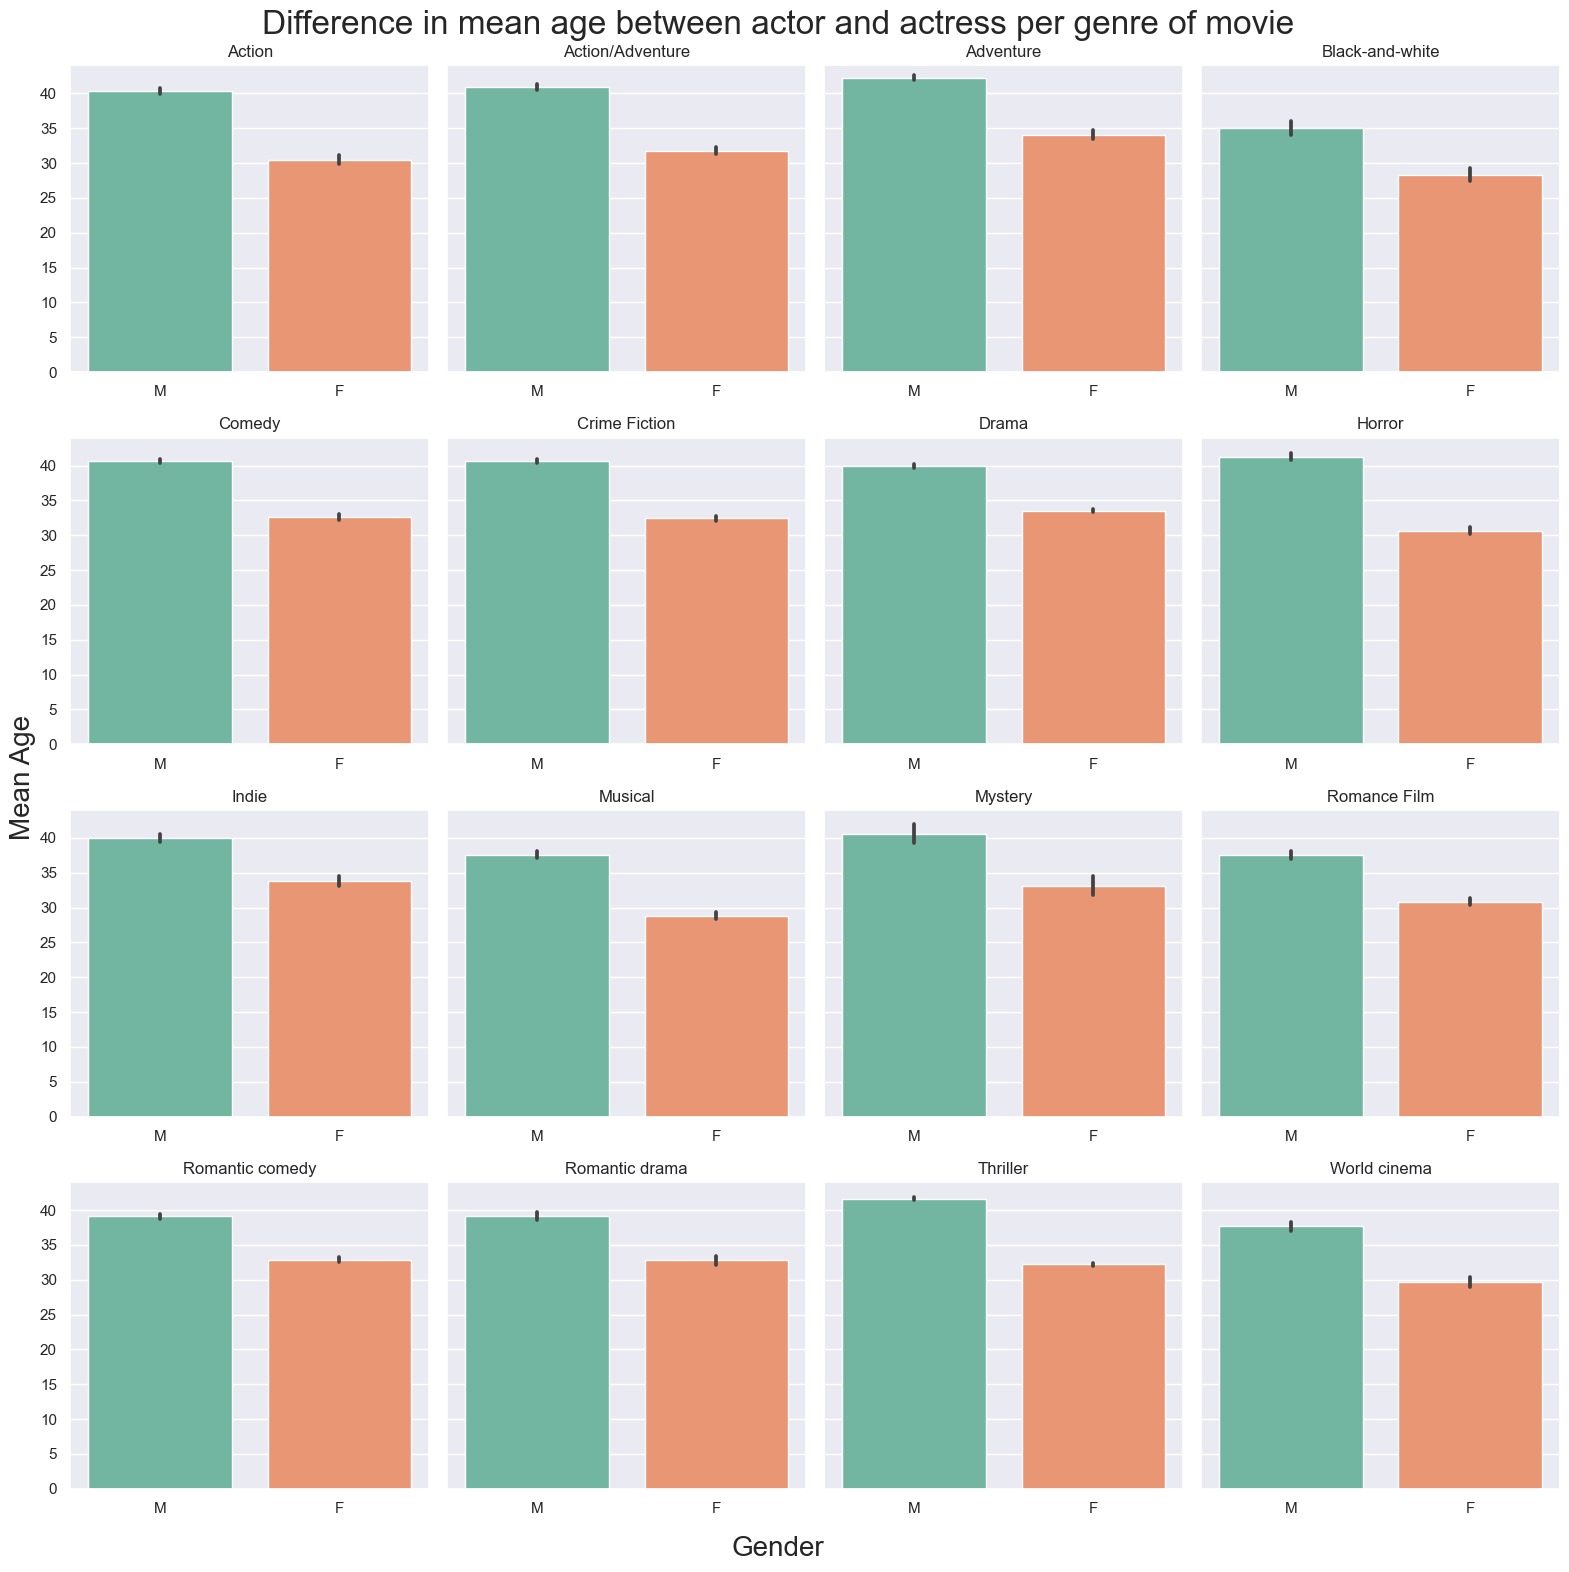

In [22]:
cmu_by_genre = cmu_genre.groupby('MovieGenre')

fig, axes = plt.subplots(4,4,figsize= (16,16), sharey=True)

for genre, ax in zip(cmu_by_genre.groups.keys(), axes.flat):
    sns.set(style="darkgrid", palette="Set2")
    
    plot = sns.barplot(x='Gender', y='Age', data=cmu_by_genre.get_group(genre), ax=ax, order=['M', 'F'], errorbar=('ci',95))
    plot.set_title(genre)
    plot.set(ylabel=None)
    plot.set(xlabel=None)
    plot.set(ylim = (0,44))

fig.supxlabel('Gender', fontsize=20)
fig.supylabel('Mean Age', va='center', rotation=90, fontsize=20)
fig.suptitle('Difference in mean age between actor and actress per genre of movie', fontsize=24)

plt.tight_layout()

plt.show()

---

## Is there a difference in revenue and popularity between female-dominated and male-dominated films?

---

We want to analyse whether the success of a movie is correlated with the proportion of women in a movie. To to this we will take the Box Office Revenue as a measure of success, as well as the IMDb ratings given around the world to each movie.

### Looking at the ratings

In [23]:
# IMDb data set merged with the CMU movies
ratings = pd.read_csv(RATINGS_PATH, sep='\t',)
ratings.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear,AverageRating,NumberofVotes
6640,10506215,/m/02qg4xb,I Capture the Castle,2003-05-09,6586341.0,113.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{""/m/06cvj"": ""Romantic comedy"", ""/m/04xvlr"": ""...",2003.0,6.8000,7877.0
4632,25658664,/m/09v262s,The Body,1970,NaN,93.0,{'/m/02h40lc': 'English Language'},{},"{""/m/0jtdp"": ""Documentary""}",1970.0,5.3601,13346.0


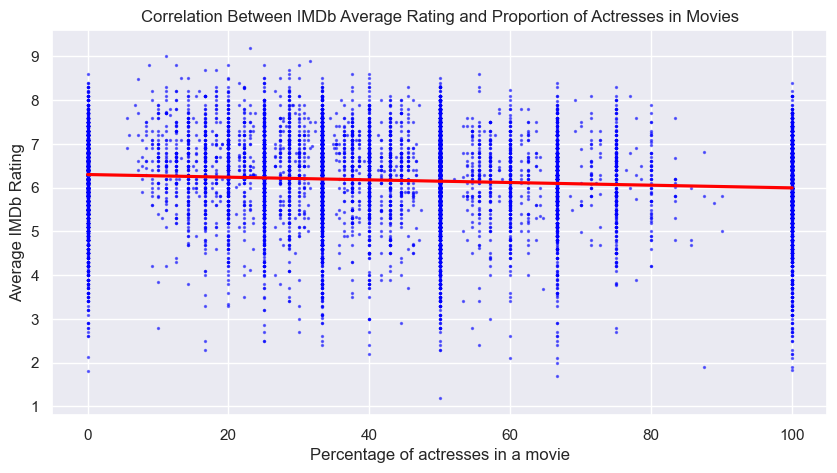

In [24]:
# We're interested only in movies for which we have information on gender distribution, so we perform a right join
ratings_gender = pd.merge(ratings, df_gender_proportion_by_movie, on='WikiMovieID', how='right')

# Sort the values according to Percentage of Female 
ratings_gender.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=ratings_gender['PercentageofFemale'], y=ratings_gender['AverageRating'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.ylabel('Average IMDb Rating')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between IMDb Average Rating and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the rating given on IMDb. This shows us that there is a slight negative correlation, meaning that movies with a higher percentage of women tend to have a slightly worse rating. We need to check this with other statistical metrics. 

### Looking at the Box office revenue

Aside from how a movie has been rated on IMDb, it is also interesting to look at its comercial success. This gives another insight on how the movie was globally percieved and if it impacted a lot of people or not. Therefore we are now looking at the boxoffice revenue of movies where we have the information from the original CMU data set. 

/var/folders/1q/sdwjt0592xxg17168tkyk87m0000gn/T/ipykernel_78971/2691133020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BO_ratings.sort_values(by='PercentageofFemale', inplace=True)


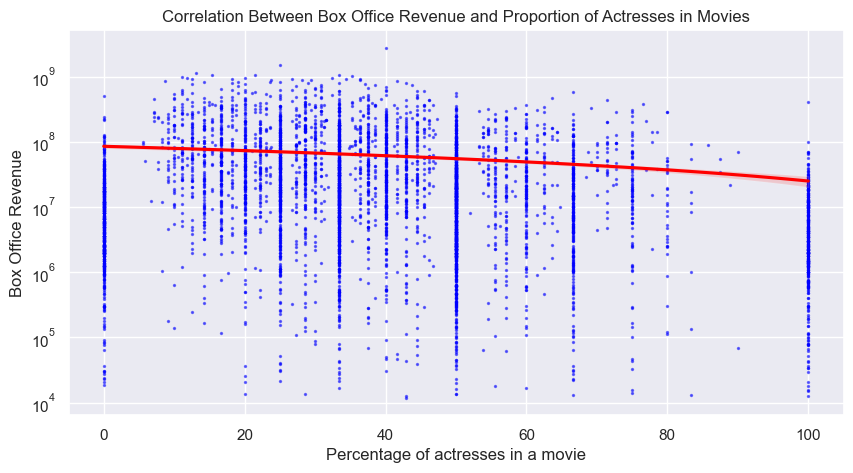

In [25]:
# Remove movies where we don't have the Box Office Revenue.
BO_ratings = ratings_gender.dropna(subset = 'BORevenue')

# Sort the values according to Percentage of Female 
BO_ratings.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=BO_ratings['PercentageofFemale'], y=BO_ratings['BORevenue'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.yscale("log")
plt.ylabel('Box Office Revenue')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between Box Office Revenue and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the Box Office Revenue. This shows us that there is a negative correlation, meaning that movies with a higher percentage of women tend to have a lower Box Office Revenue. We need to check this with other statistical metrics. 

---

## What is the typical carrier of men and women ?

---

In [26]:
movies_per_actress = women_cmu.groupby('ActorName').size().reset_index(name='number_of_movies')
movies_per_actor = men_cmu.groupby('ActorName').size().reset_index(name='number_of_movies')

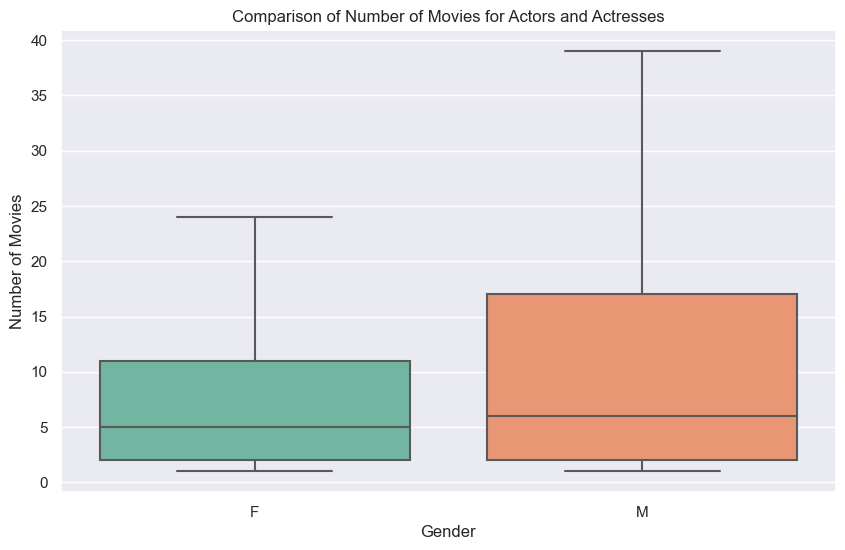

In [27]:
# Combine the two DataFrames into a single DataFrame
movies_per_actor_and_actress = pd.concat([movies_per_actress.assign(gender='F'), 
                                          movies_per_actor.assign(gender='M')])

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='number_of_movies', data=movies_per_actor_and_actress, showfliers=False)
plt.xlabel('Gender')
plt.ylabel('Number of Movies')
plt.title('Comparison of Number of Movies for Actors and Actresses')
plt.show()

---

## What are the types of characters women interpret ? 

---

Let's uncover whether the common stereotypes about women align with the characters we observe on the screen.


For this analysis, we will use the tvtropes.clusters file

In [28]:
with open(CHARACTER_TYPE_PATH, 'r') as file:
    lines = file.readlines()
    new_lines = []
    
    for line in lines:
        char_type = line.split()[0]
        char_type_dict = {'CharType': char_type}

        space_index = line.find('	')
        char_info = ast.literal_eval(line[space_index+1:])
        
        new_line = {**char_type_dict, **char_info}
        
        new_lines.append(new_line)
    

# Evaluate each line and extract the column name and corresponding dictionary

headers_names = ['CharType',
                 'CharName',
                 'MovieName',
                 'FreebaseActorMapID',
                 'ActorName']

chartypes = pd.DataFrame(new_lines)
chartypes.columns = headers_names
chartypes.head()

,CharType,CharName,MovieName,FreebaseActorMapID,ActorName
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [29]:
chartype_cmu = cmu.merge(chartypes, how='right', on=['FreebaseActorMapID', 'MovieName'])
chartype_women = chartype_cmu.loc[chartype_cmu['Gender']=='F'].copy(deep=True)
chartype_men = chartype_cmu.loc[chartype_cmu['Gender']=='M'].copy(deep=True)

In [30]:
women_counts = chartype_women['CharType'].value_counts().head(5)
men_counts = chartype_men['CharType'].value_counts().head(5)

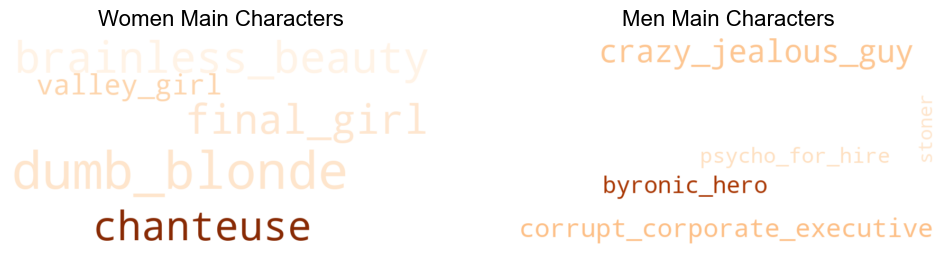

In [31]:
# Create WordClouds for women and men
women_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(women_counts)
men_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(men_counts)

# Plotting the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(women_wordcloud, interpolation='bilinear')
plt.title('Women Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(men_wordcloud, interpolation='bilinear')
plt.title('Men Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.show()

## Genre distribution per year

In [32]:
women_cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
376457,6089288,/m/0fpm3d,The Hammer,2007,NaN,88.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01z02hx': 'Sports', '/m/02l7c8': 'Romance...",Nicole,F,1.68,NaN,Constance Zimmer,36.0,/m/0gc74r7,/m/0h2jp_4,/m/0bjwgn,2007.0
290762,454223,/m/02bg6w,Pretty in Pink,1986-02-28,40471663.0,96.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06cvj': 'Romantic comedy', '/m/01t_vv': '...",Iona,F,1.60,NaN,Annie Potts,33.0,/m/0k22fz,/m/0h5qpx8,/m/018lp7,1986.0


In [33]:
# Count number of women character per movie per year
#women_character_per_year = women_cmu.groupby(['ReleaseYear', 'MovieName'])['CharacterName'].count().reset_index(name='number_of_women')
women_character_per_year = women_cmu.groupby('ReleaseYear')['CharacterName'].count().reset_index(name='number_of_women')
women_character_per_year.sample(5)

,ReleaseYear,number_of_women
80,1993.0,492
88,2001.0,1051
76,1989.0,333
24,1937.0,55
70,1983.0,208


In [34]:
# Count number of women character per movie per year
#men_character_per_year = men_cmu.groupby(['ReleaseYear', 'MovieName'])['CharacterName'].count().reset_index(name='number_of_men')
men_character_per_year = men_cmu.groupby('ReleaseYear')['CharacterName'].count().reset_index(name='number_of_men')
men_character_per_year.sample(5)

,ReleaseYear,number_of_men
17,1931.0,61
26,1940.0,113
39,1953.0,177
81,1995.0,884
2,1916.0,0


In [35]:
# Total number of women character per movie per year
# total_character_per_year = cmu.groupby(['ReleaseYear', 'MovieName'])['CharacterName'].count().reset_index(name='number_of_character')
total_character_per_year = cmu.groupby('ReleaseYear')['CharacterName'].count().reset_index(name='number_of_character')
total_character_per_year.sample(5)

,ReleaseYear,number_of_character
83,1996.0,1880
45,1958.0,281
93,2006.0,3848
64,1977.0,401
35,1948.0,200


In [36]:
# Merge and compute proportion
proportion_character_per_year = total_character_per_year.merge(men_character_per_year, on=('ReleaseYear'), how='left').merge(women_character_per_year, on=('ReleaseYear'), how='left')
proportion_character_per_year['percentage_women'] = proportion_character_per_year['number_of_women'] / proportion_character_per_year['number_of_character'] * 100
proportion_character_per_year['percentage_men'] = proportion_character_per_year['number_of_men'] / proportion_character_per_year['number_of_character'] * 100
proportion_character_per_year

,ReleaseYear,number_of_character,number_of_men,number_of_women,percentage_women,percentage_men
0,1912.0,1,NaN,1,100.000000,NaN
1,1914.0,3,1.0,2,66.666667,33.333333
2,1915.0,2,1.0,1,50.000000,50.000000
3,1916.0,6,0.0,6,100.000000,0.000000
4,1917.0,4,1.0,3,75.000000,25.000000
...,...,...,...,...,...,...
95,2008.0,3634,2114.0,1520,41.827188,58.172812
96,2009.0,3874,2282.0,1592,41.094476,58.905524
97,2010.0,3686,2275.0,1411,38.279978,61.720022
98,2011.0,3275,2005.0,1270,38.778626,61.221374


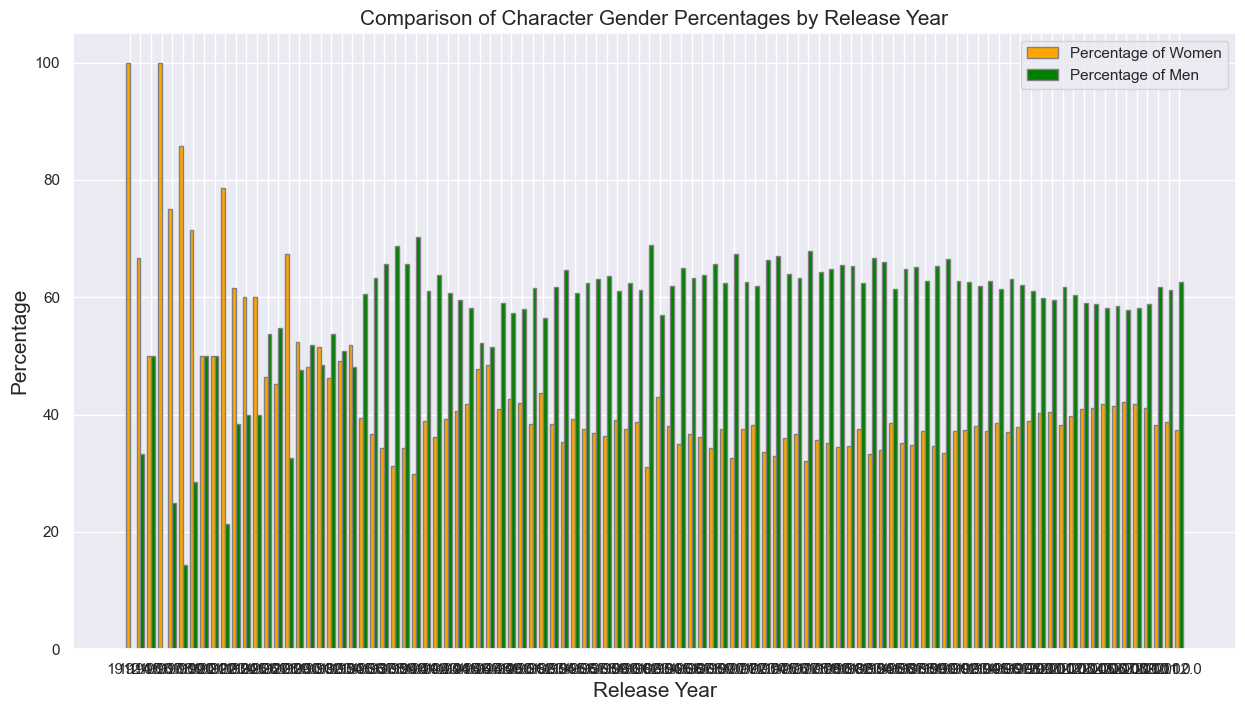

In [37]:
# Plotting the data as a bar chart to compare percentages side by side for each year.
plt.figure(figsize=(15, 8))

# Setting the width of the bars
bar_width = 0.35

# Setting the positions of the bars on the x-axis
r1 = range(len(proportion_character_per_year['ReleaseYear']))
r2 = [x + bar_width for x in r1]

# Creating the bars for women and men
plt.bar(r1, proportion_character_per_year['percentage_women'], color='orange', width=bar_width, edgecolor='grey', label='Percentage of Women')
plt.bar(r2, proportion_character_per_year['percentage_men'], color='green', width=bar_width, edgecolor='grey', label='Percentage of Men')

# Adding labels to the x-axis at the bar centers
plt.xlabel('Release Year', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(len(proportion_character_per_year['ReleaseYear']))], proportion_character_per_year['ReleaseYear'])

# Adding a title and a Y-axis label
plt.title('Comparison of Character Gender Percentages by Release Year', fontsize=15)
plt.ylabel('Percentage', fontsize=15)

# Creating a legend
plt.legend()

# Show the plot
plt.show()


## A CHANGER C'EST HORRIBLE A REGARDER ##


---

# Analysis per country and continent

---

### Do we have enough movies per continent ?

In [38]:
# Remove the rows in the 'Countries' column that lack information about countries.
cmu_countries = cmu[cmu['Countries'].apply(lambda x: len(x)!=0)].copy(deep=True)

In [39]:
num_rows_dropped = len(cmu)-len(cmu_countries)
percentage_rows_dropped = (num_rows_dropped / len(cmu)) * 100
print(f'We dropped {num_rows_dropped} rows, corresponding to {percentage_rows_dropped:.2f}% of our dataset.')

We dropped 2023 rows, corresponding to 1.51% of our dataset.


In [40]:
# We convert the column type from dictionaries to a list of strings.
cmu_countries['Countries'] = cmu['Countries'].apply(lambda x: [val for val in x.values()])

To facilitate the analysis, we will utilize the ISO databases available in the pycountry library for standardized country names.

In [41]:
from functions import bulkFindCountries

cmu_countries['Countries'] = cmu_countries['Countries'].swifter.apply(bulkFindCountries)

Pandas Apply:   0%|          | 0/131878 [00:00<?, ?it/s]

We keep only the countries for which we have the alpha_2 code

In [42]:
from functions import process_countries

before = len(cmu_countries)

cmu_countries['Countries'] = cmu_countries['Countries'].apply(process_countries)
cmu_countries = cmu_countries.dropna(subset=['Countries'])

after=len(cmu_countries)
print(f'We dropped {before-after} rows, corresponding to {((before-after)/before)*100:.2f}% of our dataset.')

We dropped 146 rows, corresponding to 0.11% of our dataset.


In [43]:
# Then we can determine the continent using the alpha_2 code
cmu_countries['Continent'] = cmu_countries['Countries'].apply(lambda x: [pc.country_alpha2_to_continent_code(country) for country in x])

In [44]:
# If a row contains multiple occurrences of the same continent, eliminate the duplicates within the list
cmu_countries['Continent'] = cmu_countries['Continent'].apply(lambda x: list(dict.fromkeys(x)) if isinstance(x, list) else x)

In [45]:
# Remove the rows for which we have more than one unique continent
before=len(cmu_countries)
cmu_countries = cmu_countries[cmu_countries['Continent'].apply(lambda x: len(x) <= 1)]
after=len(cmu_countries)
print(f'{before-after} rows were dropped')

17366 rows were dropped


In [46]:
# Change the data type of the 'Continent' column from a list to a string since it now contains lists with only one element
cmu_countries['Continent'] = cmu_countries['Continent'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [47]:
# Keep only 1 row per movie to count the number of movies per continent
cmu_countries_filtered = cmu_countries.drop_duplicates(subset=['MovieName', 'ReleaseYear', 'Continent'])
counts_per_continent = cmu_countries_filtered.groupby('Continent').size()

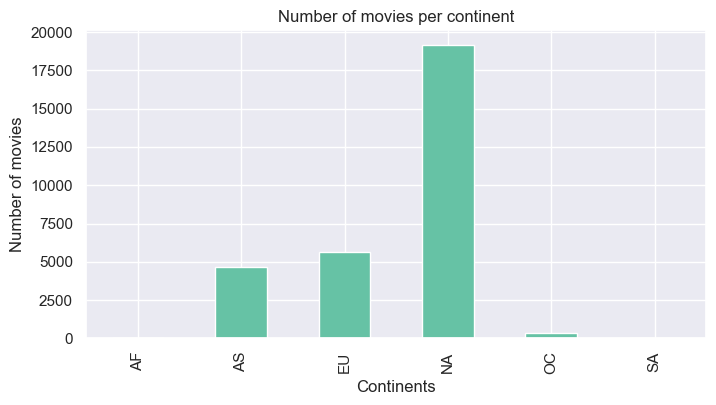

In [48]:
plt.figure(figsize=(8, 4))
counts_per_continent.plot(kind='bar')

plt.xlabel('Continents')
plt.ylabel('Number of movies')
plt.title('Number of movies per continent')

plt.show()